## Data Load

In [1]:
import pandas as pd
df = pd.read_csv('../prep/행정동별 신고데이터.csv')
bicycle = pd.read_csv('../data/자전거 사고다발지역_행정동.csv')
motor = pd.read_csv('../data/이륜차 사고다발지역_행정동.csv')

C:\Users\kdo71\AppData\Local\Temp\ipykernel_20524\3883365147.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../prep/행정동별 신고데이터.csv')


In [2]:
with open('../prep/대전_HangJeongDong_ver20230101.geojson', 'r') as f:
  dongs = ''.join(f.readlines())
  f.close()

In [3]:
# 심각성 산출 함수 정의
def cal_ECLO(bicycle, motor):
  weight = 3

  if len(bicycle.columns):
    bi_ECLO_list = 10 * bicycle['사망자수'] + 5 * bicycle['중상자수'] + 3 * bicycle['경상자수'] + 1 * bicycle['부상신고자수']
  if len(motor.columns):
    mo_ECLO_list = 10 * motor['사망자수'] + 5 * motor['중상자수'] + 3 * motor['경상자수'] + 1 * motor['부상신고자수']

  if len(bicycle.columns) * len(motor.columns):
    ECLO = bi_ECLO_list.sum() * weight + mo_ECLO_list.sum()
  elif len(bicycle.columns):
    ECLO = bi_ECLO_list.sum() * weight
  elif len(bicycle.columns):
    ECLO = mo_ECLO_list.sum()
  else:
    ECLO = 0

  return ECLO

In [4]:
geo_list = list()
for dong in eval(dongs)['features']:
  geojson = dong
  name = dong['properties']['temp'].split(' ')[1]

  df_grid = df[df['행정동'] == name]
  bicycle_grid = bicycle[bicycle['행정동'] == name]
  motor_grid = motor[motor['행정동'] == name]

  # 신고건수 cnt
  cnt = len(df_grid)

  # 심각성 계산
  if len(bicycle_grid.columns) + len(motor_grid.columns):
    ECLO = cal_ECLO(bicycle_grid, motor_grid)
  else:
    ECLO = 0

  geo_list.append([geojson, name, cnt, ECLO])
grid_df = pd.DataFrame(geo_list, columns = ['geoJSON', '행정동', '신고 건수', 'ECLO'])

In [5]:
# 이상치 확인
grid_df[grid_df['신고 건수'] > 6000]

,geoJSON,행정동,신고 건수,ECLO
18,"{'type': 'Feature', 'properties': {'OBJECTID':...",중촌동,7027,63


In [6]:
import warnings
warnings.filterwarnings(action='ignore')

# 이상치 핸들링: 이상치 값을 제외한 최댓값으로 대체
grid_df['신고 건수'][grid_df['신고 건수'] > 6000] = grid_df[grid_df['신고 건수'] <= 6000]['신고 건수'].max()
grid_df['신고 건수'][grid_df['신고 건수'] > 6000]

Series([], Name: 신고 건수, dtype: int64)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(grid_df[['신고 건수', 'ECLO']])
scaled_grid_df = scaler.transform(grid_df[['신고 건수', 'ECLO']])

# Clustering

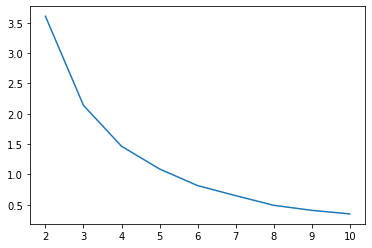

In [8]:
from sklearn.cluster import KMeans
import seaborn as sns

def visualize_inertia(cluster_lists, X_features):
    inertias = []
    for n_cluster in cluster_lists:
        k_means = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        k_means.fit(X_features)
        inertias.append(k_means.inertia_)
        
    sns.lineplot(x=cluster_lists, y=inertias)
visualize_inertia([i for i in range(2, 11)], scaled_grid_df)

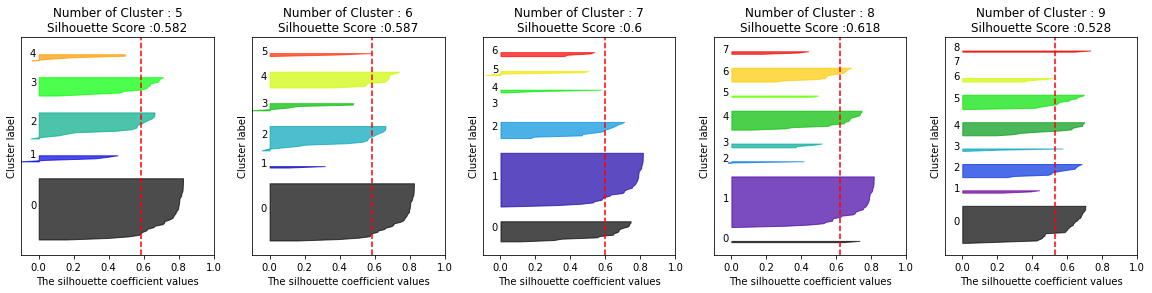

In [9]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


def visualize_silhouette(cluster_lists, X_features):     
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

visualize_silhouette([5, 6, 7, 8, 9], scaled_grid_df)

In [10]:
# KMeans 인스턴스 생성
kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=300, random_state=41)
kmeans.fit(scaled_grid_df)

# KMeans 인스턴스의 라벨 출력
print(kmeans.labels_)
 
# 군집 별 개수 출력
grid_df['cluster'] = kmeans.labels_
cluster_result = grid_df.cluster.value_counts()
print(cluster_result)

[7 2 2 2 2 0 7 5 6 2 7 6 0 2 2 7 5 2 4 6 2 2 2 2 2 7 0 2 6 2 0 2 1 2 0 7 2
 2 7 3 7 3 5 0 0 1 5 1 0 2 0 2 2 2 5 2 5 4 5 7 5 7 7 2 2 1 2 5 0 5 2 2 7 2
 5 2 7 2 3 0 0 5]
2    32
7    13
0    12
5    12
6     4
1     4
3     3
4     2
Name: cluster, dtype: int64


In [11]:
# !pip install koreanize_matplotlib
import koreanize_matplotlib
import warnings
warnings.filterwarnings(action = 'ignore')

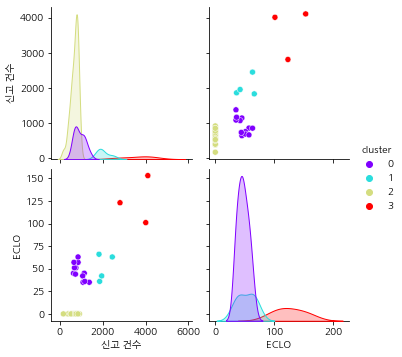

In [12]:
sns.pairplot(hue='cluster',
   palette='rainbow',
   data=grid_df[grid_df['cluster'] < 4],
   vars=['신고 건수', 'ECLO'])
plt.show()

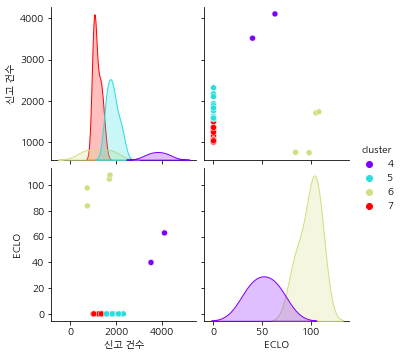

In [13]:
sns.pairplot(hue='cluster',
   palette='rainbow',
   data=grid_df[grid_df['cluster'] > 3],
   vars=['신고 건수', 'ECLO'])
plt.show()

## 군집을 활용한 위험 등급 분류
- cluster 0: 사고가 잦지는 않으나 중간정도 ECLO
	- 25 <= ECLO <= 75
	- 500 <= 신고 건수 <= 1500
- clu7-ster 1: 신고가 잦으나 중간정도 ECLO
	- 25 <= ECLO <= 75
	- 1600 <= 신고건수 <= 2500
- cluster 2: 사고 자체가 잘 일어나지 않음
	- ECLO ~= 0
	- 신고건수 <= 1000 
- cluster 3: 높은 ECLO와 많은 신고건수를 동반
	- 90 <= ECLO: <= 160
	- 신고건수 >= 2500 and <= 4500 
- cluster 4: 매우 잦은 사고, 중간정도 ECLO
	- 35 <= ECLO <= 70
	- 신고건수 >= 3000
- cluster 5: 잦은 사고, 이륜차 입장에서 심각하지는 않음
	- ECLO == 0
	- 1500 <= 신고건수 <= 2500
- cluster 6: 신고건수에 비해 ECLO가 굉장히 높음
	- 80 <= ECLO <= 120
	- 500 <= 신고건수 <= 2000
- cluster 7: 잦은 사고신고, 이륜차 입장에서 심각하지는 않음
	- ECLO ~= 0
	- 900 <= 신고건수 <= 1600

위험순위: 3 -> 6 -> 0 -> 1 -> 4 -> 5 -> 7 -> 2
위험순위 cluster
- cluster 0, 1은 비슷하여 한 클러스터로 묶음
- cluster 5, 7은 비슷하여 한 클러스터로 묶음

위험순위 결정 기준
1. 높은 ECLO
2. ECLO 범위가 비슷하다면 적은 교통사고 신고건수
3. ECLO가 0이라면 많은 신고건수

In [28]:
def danger_grade(cluster):
    # 총 5개 위험 등급으로 분류
    if cluster == 3:
      return 1
    if cluster == 6:
      return 2
    if cluster == 0 or cluster == 1:
      return 3
    if cluster == 4:
      return 4
    if cluster == 5 or cluster == 7:
      return 5
    if cluster == 2:
      return 6

grid_df['cluster'] = grid_df['cluster'].apply(danger_grade)

In [29]:
grid_df['신고 건수'][grid_df['행정동'] == '중촌동'] = 7027
grid_df[grid_df['행정동'] == '중촌동']

,geoJSON,행정동,신고 건수,ECLO,cluster
18,"{'type': 'Feature', 'properties': {'OBJECTID':...",중촌동,7027,63,4


중촌동의 신고 건수를 원래대로 복원하여도 cluster 분류에 이상이 없다.

In [32]:
grid_df.to_csv('clustered_df.csv', index=False)